# A Python interface to IWAVE

This notebook describes the modeling package IWAVE and some convenient  Python interfaces to it. IWAVE manipulates data in two disk storage formats commonly used in the geophysical research community, especially the industry-oriented part:

1. SEGY traces, in the form popularized by Seismic Unix from Colorado School of Mines, and
2. RSF gridded data, from the Madagascar project at UT Austin.

Like almost all scientific data, these data structures consist of arrays of data samples, together with "metadata" describing their meaning - sample rates, numbers of samples, units, etc.

IWAVE treats the data arrays as vectors, and the metadata as defining vector spaces. That is, only data arrays sharing the same metadata can participate in pairwise vector operations (linear combination, dot product). IWAVE finite difference simulators for wave equations are set up to read and write their necessary data from SEGY and RSF files, and  define linear or nonlinear operators between the vectors spaces specified by the file metadata. IWAVE is written in C/C++.

The Python interface to IWAVE accesses executable IWAVE commands via system calls. Arguments to functions in this interface are combined to form commands in the form of Python strings, which are then fed to the command line via *os.system(...)*. 

This interface consists of two modules:

*linalg* defines linear algebra operations and a simple plotting interface for data vectors stored in either SU or RSF format. The operations include

1. copy(x,y) - does what you'd think, copies x over y.
2. lincomb(a,x,y,b=1.0) - classic axpy with the default for the fourth argument, otherwise y=a*x+b*y.
3. norm(x) - returns L2 norm, that is, l2 norm weighted by grid element volume (rsf) or dt (su)
4. dot(x,y) - inner product, defined similarly to norm
5. simplot(f, addcb=False, width=7, asprat=-1) - simple matplotlib interface to plot SU or RSF file f, either as a line plot (1D data) or color scale (2D data). The 2D case offers several optional inputs: addcb toggles colorbar, width is in inches, asprat (aspect ratio) defaults to either 1 (for su gathers) or 1:1 for rsf. This utility is intended for simple "quick and dirty" standard plots in jupyter notebook use. For more involved plotting (eg. scale control, multiple lines in different colors, ray overlays on color scale plots, and so on), users will have to code appropriate plotting commands from scratch. 

*op* provides access to acoustic staggered grid finite difference simulator in IWAVE, with most parameters defaulted to values appropriate for the set of examples presented here. Some of these parameters may be worth turning into keyword params with defaults. 

This finite difference simulator implements $m, w \mapsto F[m]w=d$, in the notation of our papers. The function interface is
*fdop(m, w, d)*: m = bulk modulus model RSF format (input, buoyancy = 1 cm^3/g), w = source in SU format (input), d = pressure traces SU format (output). All files including output must exist on call. In particular output file must be initialized before calling this function, and is overwritten. Two interpretations: (1) linear operator $F[m]: w \mapsto d$ or (1) nonlinear operator $F[\cdot]w: m \mapsto. d$.

*op* also provides a function implementing the convolutional representation of the simulator. This representation is far less computationally expensive than the finite difference simulator for repeated simulation with different sources, as is required in an iterative estimation of sources. For use in least-squares algorithms, a convolutional representation of the adjoint  operator ($F[m]^T$) is also provided. 

The function interface for the convolutional representation is *convop(g, w, d, adj)*: g is a Green's function, pre-computed by applying *fdop* to a digital delta function $\delta$. *adj* is an integer flag with default value 0, indicating application of the forward (adj = 0) or adjoint (adj $\ne$ 0) operator. 

## Example

It's easiest to explain how all of this really works via an example. The module *data* defines the components of this example via Python functions. 

The bulk modulus is a low-velocity lens, minimum value 1.6 GPa, in a constant background of 4 GPa. It is sampled on a regular rectangular grid of size 4000 m (depth, z, 1st axis) $\times$ 8000 m (horizonal, x, 2nd axis), with sample steps of 20 m in both directions. The data and metadata are stored as RSF files: the metadata (axis descriptions) in an ascii (human-readable) file 'bml0.rsf' in the working directory, and the data in a binary file 'bml0.rsf@' somewhere else (the RSF default is /var/tmp, but you can choose some other part of the file system to store binary data - see the Madagascar documentation).  While the buoyancy plays the role of a parameter, rather than an argument to $F$, it must be supplied to fully define the acoustic model. For this example, it is constant at 1 cm$^3$/g. The function *model* in the data module creates both (the buoyancy file name is always the bulk modulus file name prefixed with "by"):

In [1]:
import data

data.model(bulkfile='bml0.rsf',bulk=4.0, nx=401, nz=201, dx=20, dz=20, lensfac=0.4)

The function linalg.simplot gives a quick look at the bulk modulus data. I've used the 'addcb' optional input to add a color bar at the right edge. For a publication quality plot, you would want to tinker with the matplotlib command to make the aspect ratio = 1, so that the lens would appear circular (which it is). This really is just a quick look!

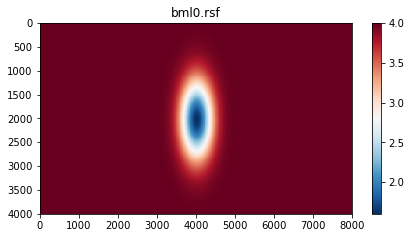

simplot: data min = 1.6019e+00, data max = 4.0000e+00


In [2]:
import linalg

linalg.simplot('bml0.rsf', addcb=True)

IWAVE represesnts sources and data traces (a function of time obtained from a function of space-time by sampling at a specified point in space) as SEGY traces (SU's standard data format). Sources (right-hand sides in wave equations, $w$ in $F[m]w$) are presumed to be sums of spatial deltas multiplied by functions of time. So the SEGY trace data represents the function of time, and the SEGY metadata (specifically header words gx and gelev) locate the spatial delta in depth z and horizontal position x.

One might think that the amplitude of each SEGY trace should also be scaled by the reciprocal spatial cell volume, to for a gridded imitation of a spatial delta function. That is true, but it is done *internally* by IWAVE, so there is no need to do so externally. Also, locations of sources are completely arbitrary: IWAVE transfers them to functions on the grid by adjoint interpolation.

In this example, an isotropic point source is positioned at z=3500 m, x=3500 m. The wavelet (time function) is a trapezoidal bandpass filter, with corner frequencies 1, 2.5, 10, 12.5 Hz. An SU script to generate it uses the commands 

1. suspike, to generate a trace with a single nonzero (1.0) at a specified time;
2. sugain, to scale by 1/$\Delta t$ for a discrete delta function of time;
3. sufilter, to apply a bandpass filter;
4. sushw, to set header words for source and receiver positions.

The compound command is built in the function bpfilt in the data module. It's all laid out in the *linalg.bpfilt* source. 

NOTE: An annoying twist, which you have to learn by experience because SU documentation is really inadequate on the subject of units: for suspike, dt (= $\Delta t$) has to be given in s (seconds), but IWAVE expects times to be given in ms (milliseconds), to scale the delta function properly for input into IWAVE. Even worse, the SEGY standard requires that the time step be given in $\mu$s (microseconds) - in order that it be represented by a short integer (the standard dates to 1975, when mass storage was orders of magnitude less capable thaan it is today).

In any case, IWAVE applications expect lengths in m, times in ms. So velocities are in m/ms = km/s. IWAVE wants mass in Mg = megagrams = 10$^6$ g = 10$^3$ kg, which seems odd until you realize that then the natural unit of density is Mg/m$^3$ = g/cm$^3$, and of pressure is GPa = 10$^9$ Pa = 10$^9$ Kg/(m s$^2$) = Mg/(m ms$^2$). Typical geophysical quantities are $O(1)$ in these units. Also, a megagram is the same as a metric ton (tonne).


In [3]:
import data

data.bpfilt('ptsrc0.su',251,8.0,1.0,1.0,2.5,7.5,12,3500,3500)


The source wavelet is stored in ptsrc0.su, and looks like this:

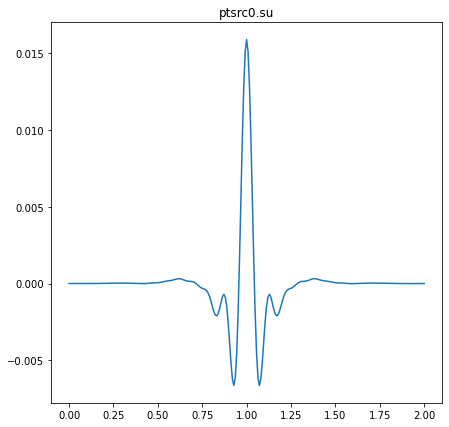

In [4]:
import linalg
linalg.simplot('ptsrc0.su')

## Finite Difference Modeling

The input model ($m$) and source ($w$) have been constructed, so now you can apply the modling operator $F[m]$ to $w$ to create some trace data. 

The modeling code has several steps:

1. create a file of SEGY traces having correct headers for the output. The data samples don't matter, and can all be zero. The function rechdr from module data does this: it creates a header file with source depth (sz) = 3500 m, source position (sx) = 3500 m, receiver depth (rz) = 1000 m, 201 receivers spaced uniformaly from rxmin=2000 m to rxmax = 6000 m, time step dt=8 ms, first sample (delrt) = 0, number of time samples in each trace (nt) = 626 (so 5 s long traces). If you look at the SU script, you will notice that depths are given as elevations, which are negative depths.

In [5]:
import data
data.rechdr(file='rechdr0.su',nt=626,dt=8.0,rxmin=2000,rxmax=6000,ntr=201,rz=1000,sx=3500,sz=3500)



2. copy rechdr0.su over the output file recplh0.su. rechdr0.su specifies the correct trace geometry (in particular, reciever locations), but all of its samples are zero. This step is required because the simulation command does not create the output file, only modifies it with data samples. The trace geometry must be present in the output file on call.

3. call the simulator code op.fdop with m=bml0.rsf, w=ptsrc0.su, and d=recplh0.su. The output file d is overwritten with the simulator output.

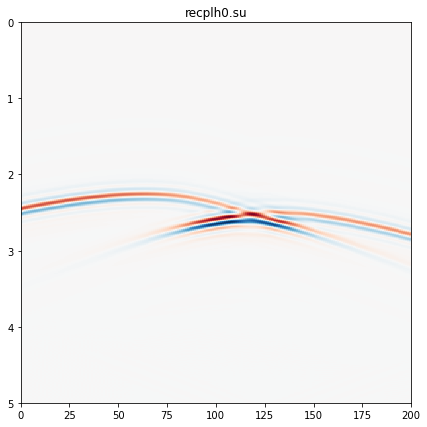

simplot: data min = -5.7946e-06, data max = 5.6761e-06


In [6]:
import linalg
import op

linalg.copy('rechdr0.su','recplh0.su')
op.fdop(m='bml0.rsf',w='ptsrc0.su',d='recplh0.su',adj=0)
linalg.simplot('recplh0.su')


## Convolutional Representation

Because the coefficients in the wave equation are time-independent, shifting the right-hand side in time is equivalent to shifting the solution in time. Since the solution is linear in the right-hand side, convolution of the solution with a function of time is equivalent with convolution of the right-hand side with the same function of time. In particular, the solution of the wave equation with a point isotropic radiator right-hand side $w(t)\delta(x-x_s)\delta(z-z_s)$ is the same as the convolution of $w(t)$ with the solution with right-hand side $\delta(t)\delta(x-x_s)\delta(z-z_s)$. This latter solution is often called (somewhat improperly) a Green's function.

To calculate a Green's function for the source location of this example, build a discrete version of $\delta(t)\delta(x-x_s)\delta(z-z_s)$. This is a single SEGY trace with the source position coded as part of the SEGY metadata, and a single non-zero time sample with amplitude $1/\Delta t$ at $t=0$. This amplitude makes value of the trapezoidal-rule approximate integral of the product with another trace the value of that trace at $t=0$, imitating the defining property of the delta function.

Note that the scaling natural for the discrete version of the *spatial* delta function $\delta(x-x_s)\delta(z-z_s)$ is performed internally by IWAVE.

The function *delta* in the *data* module performs this calculation.

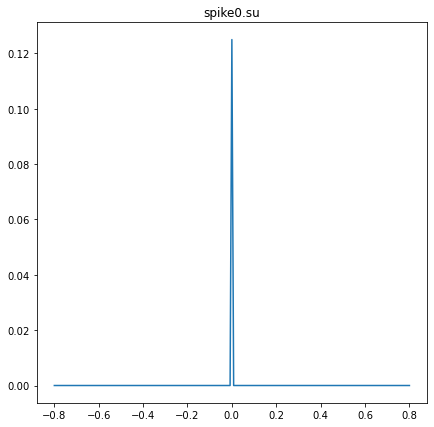

In [7]:
import linalg
import op
import data

data.delta('spike0.su',nt=201,dt=8.0,sx=3500,sz=3500)

linalg.simplot('spike0.su')


Now apply the modeling operator $F[m]$ to the discrete approximation of $w=\delta(t)$ stored in 'spike0.su':

In [8]:
import op
import linalg

linalg.copy('rechdr0.su','greenl0.su')
op.fdop(m='bml0.rsf',w='spike0.su',d='greenl0.su')


True

The result looks extremely noisy, and indeed this is not a pointwise accurate approximation. To see what Green's functions look like, see the report "Calibrating IWAVE" and references cited there. They are quite smooth, except at wavefronts which are space-time surfaces (so occupying measure zero in the continuum limit).

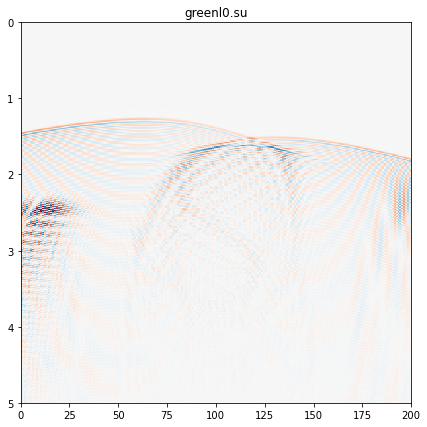

simplot: data min = -3.0467e-05, data max = 3.1319e-05


In [9]:
linalg.simplot('greenl0.su')

However, most of this highly oscillatory garbage cancels out when convolved with a relatively smooth, well-sampled wavelet such as the bandpass filter used here:

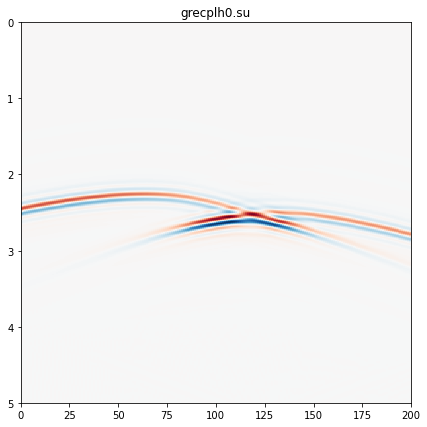

simplot: data min = -5.7947e-06, data max = 5.6761e-06


In [10]:
import op
import linalg

linalg.copy('rechdr0.su','grecplh0.su')
op.convop(g='greenl0.su',w='ptsrc0.su',d='grecplh0.su')
linalg.simplot('grecplh0.su')

This looks almost exactly like the finite difference simulation. A quick test of exactly how close the two are is to compute the norm of the finite difference simulation and of the difference between it and the convolutional simulation, and compare:

In [11]:
import linalg

linalg.copy('recplh0.su', 'diffrecplh0.su')
linalg.lincomb(-1.0,'grecplh0.su','diffrecplh0.su')
print('fd norm   = ' + str(linalg.norm('recplh0.su')))
print('diff norm = ' + str(linalg.norm('diffrecplh0.su')))


fd norm   = 0.000449395
diff norm = 2.8583e-07


So the difference is more than three orders of magnitude smaller than the reference fd result. Seismic data in the field has far more noise than that, so for the ultimate purpose of this exercise, the finite difference and convolutional results are interchangeable.

The convolutional representation, however, has a great advantage: it requires orders of magnitude fewer flops. That is very important for iterative use, as in inversion for source.

NB: *op.convop* implements two use cases. The first is used in this notebook: the input source file *w* contains only one trace (it's a source wavelet). In forward mode, every trace in the Green's function is convolved with the (single) source trace to produce an output data trace. In adjoint mode, every data trace is adjoint-convolved (cross-correlated) with the corresponding Green's function trace and the result added to the output source trace The second case requires that the source file contain as many traces as the Green's function. In this second use case, forward (adjoint) mode convolves (adjoint-convolves) each source (data) trace with the corresponding trace in the Green's function to produce an output data (source) trace. This second use case is important for Adaptive Waveform Inversion, in which every data trace is explained by its own proper source (see the notebook on AWI).

## Adjoints

The adjoint $A^T$ of the linear map $A: X \rightarrow Y$ maps a vector in the range to a vector in the domain, so that the condition
$$
\langle Ax, y \rangle_Y = \langle x, A^T y \rangle_X           
$$ 
holds for any $x \in X, y \in Y$. Here $\langle \cdot,\cdot \rangle_X$ and $\langle \cdot,\cdot \rangle_Y$ denote inner products in $X$ and $Y$ respectively.

We will need access to the adjoint $F[m]^T$ of the linear map $F[m]$ as part of the solution of least squares formulations of source inversion. Iterative methods will apply this operator and its adjoint repeatedly, so the convolution representation (much cheaper than the finite difference computation) is preferred. The function *op.convop(g,w,d,adj=1)* does the job: the inputs are g = Green's function (pre-calculated using *op.fdop*), d = data traces, and the output is w = trace of same dimensions and metadata as source wavelet.

For example, use for the input vector $d$ (a vector in the range of $F[m]$) the output of the last example (recplh0.su), and apply the adjoint operator to it to produce an output vector $w$ in the domain of $F[m]$ (the input vector space of the last example, like ptsrc0.su). As always for IWAVE operators, the output vector must be initialized with the correct metadata before application of $F[m]$, so that it defines the domain space, where the output of the adjoint should be. A simple way to do that is to copy ptsrc0.su (the input of the last example) onto adjout.su, so that both define the same vector space. 

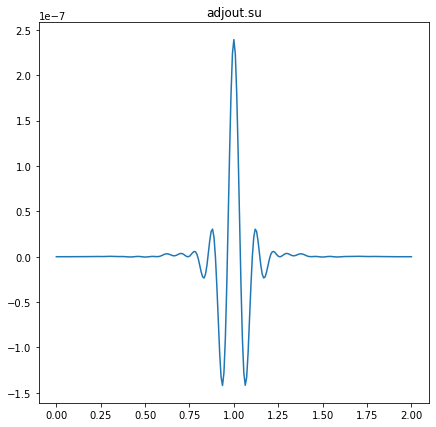

In [12]:
import linalg
import op

linalg.copy('ptsrc0.su','adjout.su')
op.convop(g='greenl0.su',w='adjout.su',d='recplh0.su',adj=1)
linalg.simplot('adjout.su')

At this point I have merely claimed that *op.convop(...,adj=1)* defines the adjoint of *op.convop(...,adj=0)*. You can't tell that this claim is correct by looking at the plot of adjout.su. You have to check the defining property of the adjoint. In this example, ptsrc0.su is the input $w$ to the forward map $F[m]$, producing output $d=F[m]w=$recplh0.su, and $d=F[m]w=$recplh0.su is the input to the adjoint, producing output $F[m]^Td = F[m]^TF[m]w=$adjout.su. The defining property implies that $\langle w, F[m]^T d\rangle = \langle w, F[m]^TF[m]w \rangle$ should be the same as $\langle F[m]w,d\rangle = \langle F[m]w,F[m]w\rangle$ (the appropriate inner products in each case). Translated in terms of the SEGY files representing the various vectors this says that two outputs of *linalg.dot* should be the same:

In [13]:
print('<F[m]w, F[m]w> = ' + str(linalg.dot('recplh0.su','recplh0.su')))
print('<w, F[w]^TF[m]w> = ' + str(linalg.dot('ptsrc0.su','adjout.su')))
#print(str(linalg.norm('ptsrc0.su') * linalg.norm('adjout.su')))

<F[m]w, F[m]w> = 2.01956e-07
<w, F[w]^TF[m]w> = 2.01956e-07


which they are, to six digits - the best that can be hoped for, since IWAVE computations are carried out in single precision.

The test we have just completed (the "dot product test") shows that the defining property of the adjoint holds for one particular pair of vectors in domain and range of $F[m]$, and a priori says nothing about any other vectors. However the defining property is supposed to hold for *all* pairs of vectors. How can you check that? Answer: you can't! The dot product test, if passed in a particular instance, simply *fails* to show the the implemented operators are *not* adjoint to each other. A typical use of the dot product test is to populate the test vectors with random numbers, on the presumption that tests with such random numbers will only pass if the implemencted operators are adjoint to each other with high probability. However random vectors are not "typical" in high dimensional vector spaces: they are very oscillatory (from one component to the next) and the oscillations may induce cancellation that mimics the hoped-for result of the dot product test. 

Still, the dot product test is really the only QC tool we have, so the best policy is to use it, a lot. Here is a random vector dot product test, using the random vector creation function *linalg.rand*. In typical IWAVE fashion, the filename passed to this function must be that of an existing RSF or SU file. In either case, the metadata is left alone, and the data samples replaced by pseudorandom numbers in the range [-1,1]. Note that some of the metadata is changed from the previous example, and all steps of the test are carried out, including creation of the Green's function.

In [14]:
import linalg
import op
import data

# bulk modulus with less focussing lens
data.model(bulkfile='m.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20, lensfac=0.7)
# create delta function at sx=4200, sz=3000 
data.delta(file='w.su', nt=201, dt=8.0, sx=4200, sz=3000)
# create corresponding data file with rz=500, same range of rx
data.rechdr(file='d.su',nt=626,dt=8.0,rxmin=2000,rxmax=6000,ntr=201,rz=1000,sx=4200,sz=3000)
# compute green's function
linalg.copy('d.su','g.su')
op.fdop(m='m.rsf',w='w.su',d='g.su')
# randomize w, d
linalg.rand('w.su')
linalg.rand('d.su')
# forward map w to F[m]w
linalg.copy('d.su','Fw.su')
op.convop(g='g.su',w='w.su',d='Fw.su',adj=0)
# adjoint map d to F[m]^Td
linalg.copy('w.su','FTd.su')
op.convop(g='g.su',w='FTd.su',d='d.su',adj=1)
# compute, display inner products
print('<d, F[m]w> = ' + str(linalg.dot('d.su','Fw.su')))
print('<F[m]^Td,w> = ' + str(linalg.dot('FTd.su','w.su')))

<d, F[m]w> = -0.112216
<F[m]^Td,w> = -0.112216


## Source Estimation via CG

Here is pseudocode for the Conjugate Gradient method for solving the least squares problem: given bulk modulus field $m$, data traces $d$, max iterations $k_{\rm max}$, residual reduction $\epsilon$, and normal residual reduction $\rho$ find a source wavelet $w$ to minimize $J_0[w] = \|F[m]w-d\|^2$.

Initialize:
1. $w = 0$
2. $e = d$
3. $r = F[m]^Td$
4. $p = r$
5. $q = F[m]p$
6. $s = F[m]^Tq$
7. $\gamma_0 = \langle r, r \rangle$
8. $\gamma = \gamma_0$
9. $k=0$
    
Repeat while $k<k_{\rm max}$, $\|e\|>\epsilon \|d\|$:
1. $\alpha = gamma / \langle q, q\rangle$
2. $w \leftarrow w+\alpha p$
3. $e \leftarrow e-\alpha q$
4. $r \leftarrow r-\alpha s$
5. $\delta = \langle r, r \rangle$
6. $\beta = \delta / \gamma$
7. $p \leftarrow r + \beta p$
8. $\gamma \leftarrow delta$
9. $q \leftarrow F[m]p$
10. $s \leftarrow F[m]^Tq$
11. $k \leftarrow k+1$
12. print $k$ (iteration) $\|e\|$ (residual norm), $\|r\|$ (normal residual norm)


Three tasks:

1. verify that this is actually the conjugate gradient method for solving the normal equation $F[m]^TF[m]w = F[m]^Td$. You can find a description in practically any Numerical Analysis textbook - for example, Algorithm 5.2 in Nocedal and Wright. I have rewritten it in a convenient form for implementation, using additional variables which are mostly necessary for storing intermediate results within a single iteration. There is no need to  store the vector values ($w$, $r$, etc.) for every iteration, however, so I have written the updates in overwrite mode rather than as rules for generating sequences, as the textbooks tend to do.

2. convert this pseudocode into a Python script using functions in the linalg and op modules to implement all of the steps.

3. use it to solve a source estimation algorithm.

Note that here $F[m]$ will indicate the convolutional representation. So you will need to include code to generate the Green's function before starting the iteration.



